In [2]:
import tweedledum as td
from tweedledum.bool_function_compiler.decorators import circuit_input
from tweedledum import BitVec
from clique_counter import parameterized_clique_counter, parameterized_clique_counter_batcher, BoolFunctionTester


import logging
logging.disable()

G has 2 cliques of size at least 2


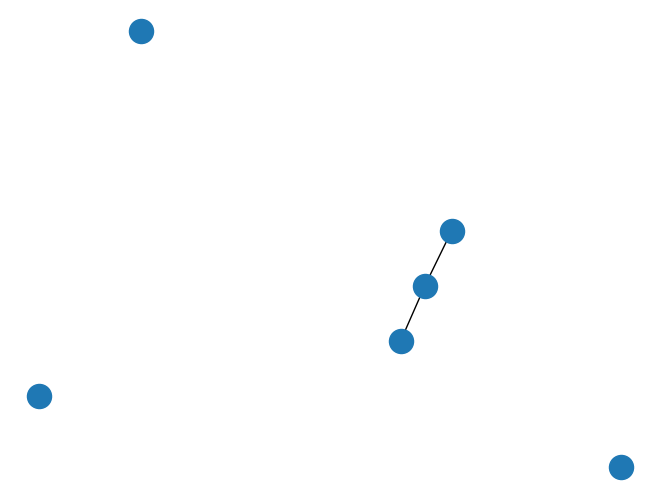

In [49]:
# Generate Random graph
import networkx as nx
import numpy as np

def graph_to_binary_edge_list(g): 
    n = g.number_of_nodes()
    return [int(G.has_edge(i, j)) for i in range(0, n) for j in range(0, n)]
    
def count_cliques(graph, k):
    from networkx.algorithms import enumerate_all_cliques
    """Classically counts cliques of size <= k."""
    cliques = list(enumerate_all_cliques(graph))
    count = len([node_list for node_list in cliques if len(node_list) >= k])
    return count

def from_last_time(target_func):
    N = 4
    k = 2
    G = nx.Graph()
    G.add_nodes_from([i for i in range(0, N)])
    G.add_edges_from([(0, 1), (0, 2), (1, 2), (1, 3)])
    edges = graph_to_binary_edge_list(G)
    src, func =  target_func(N, k, edges)
    return N, k, G, src, func

def no_solutions(target_func):
    N = 6
    k = 2
    edges = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0]
    # Reshape the flat list into an adjacency matrix
    adj_matrix = np.array(edges).reshape((N, N))

    # Create graph from adjacency matrix
    G = nx.from_numpy_array(adj_matrix)
    src, func =  target_func(N, k, edges)
    return N, k, G, src, func

def one_solution(target_func):
    N = 6
    k = 2
        #    0  1  2  3  4  5
    edges = [0, 0, 0, 0, 0, 0,    # vtx 0
             0, 0, 0, 0, 0, 0,    # vtx 1
             0, 0, 0, 0, 0, 0,    # vtx 2
             0, 0, 0, 0, 1, 1,    # vtx 3
             0, 0, 0, 1, 0, 1,    # vtx 4
             0, 0, 0, 1, 1, 0]    # vtx 5
    # Reshape the flat list into an adjacency matrix
    adj_matrix = np.array(edges).reshape((N,N))
    # Create graph from adjacency matrix
    G = nx.from_numpy_array(adj_matrix)
    src, func =  target_func(N, k, edges)
    return N, k, G, src, func



#N, k, G, src, func = from_last_time(parameterized_clique_counter_batcher)
N, k, G, src, func = no_solutions(parameterized_clique_counter)
#N, k, G, src, func = one_solution(parameterized_clique_counter_batcher)

m = count_cliques(G, k)
print(f"G has {m} cliques of size at least {k}")
nx.draw(G)


In [50]:
# -------------------------------------------------------------------------------
# Part of Tweedledum Project.  This file is distributed under the MIT License.
# See accompanying file /LICENSE for details.
# -------------------------------------------------------------------------------
from typing import Union, List
from os.path import isfile
import inspect
import math
import types

from tweedledum.bool_function_compiler.function_parser import FunctionParser
from tweedledum.classical import TruthTable, create_from_binary_string
from tweedledum import classical


class BoolFunctionTester(object):
    """Class to represent a Boolean function

    Formally, a Boolean function is a mapping :math:`f : {0, 1}^n \to {0, 1}^m`,
    where :math:`n`(:math:`m`) is the number of inputs(outputs).  There are
    many ways to represent/specify a Boolean function.  Here, we use two:

    Truth tables:  They are are an explicit and _not compact_ function
        representation.  Basically a truth table is an exhaustive mapping from
        input binary bit-strings of length :math:`n` to corresponding output
        bit-strings of length :math:`m`. Hence they do not scale well. They are,
        however, tremendously useful to represent and manipulate small functions.

    Logic network (Xor-And graph, XAG): A logic network is modeled by a directed
        acyclic graph where nodes represent primary inputs and outputs, as well
        as local functions.  The nodes representing local function as called
        gates.  In our case, we limit our local functions to be either a 2-input
        AND or a 2-input XOR---a structure known as XAG.  Therefore, a XAG is a
        2-regular non-homogeneous logic network.

    Under the hood both representations are implemented in C++.
    """

    def __init__(self, src):
        parsed_function = FunctionParser(src.strip())
        self._parameters_signature = parsed_function._parameters_signature
        self._return_signature = parsed_function._return_signature
        self._logic_network = parsed_function._logic_network
        self._truth_table = None
        self._num_input_bits = self._logic_network.num_pis()
        self._num_output_bits = self._logic_network.num_pos()

    def _format_simulation_result(self, sim_result):
        i = 0
        result = list()
        for type_, size in self._return_signature:
            tmp = sim_result[i : i + size]
            result.append(type_(size, tmp[::-1]))
            i += size
        if len(result) == 1:
            return result[0]
        return tuple(result)

    def num_inputs(self):
        return len(self._parameters_signature)

    def num_outputs(self):
        return len(self._return_signature)

    def num_input_bits(self):
        return self._num_input_bits

    def num_output_bits(self):
        return self._num_output_bits

    def simulate(self, *argv):
        if len(argv) != self.num_inputs():
            raise RuntimeError(
                f"The function requires {self.num_inputs()}. "
                f"It's signature is: {self._parameters_signature}"
            )
        input_str = str()
        for i, arg in enumerate(argv):
            arg_type = (type(arg), len(arg))
            if arg_type != self._parameters_signature[i]:
                raise TypeError(
                    f"Wrong argument type. Argument {i} "
                    f"expected: {self._parameters_signature[i]}, "
                    f"got: {arg_type}"
                )
            arg_str = str(arg)
            input_str += arg_str[::-1]

        # If the truth table was already computed, we just need to look for the
        # result of this particular input
        if self._truth_table != None:
            position = int(input_str[::-1], base=2)
            sim_result = "".join([str(int(tt[position])) for tt in self._truth_table])
        else:
            input_vector = [bool(int(i)) for i in input_str]
            sim_result = classical.simulate(self._logic_network, input_vector)
            sim_result = "".join([str(int(i)) for i in sim_result])

        return self._format_simulation_result(sim_result)

    def simulate_all(self):
        if self._truth_table == None:
            self._truth_table = classical.simulate(self._logic_network)

        result = list()
        for position in range(2 ** self._logic_network.num_pis()):
            sim_result = "".join([str(int(tt[position])) for tt in self._truth_table])
            result.append(self._format_simulation_result(sim_result))

        return result

    def logic_network(self):
        return self._logic_network

    def truth_table(self, output_bit: int):
        if not isinstance(output_bit, int):
            raise TypeError("Parameter output must be an integer")
        if self._truth_table == None:
            self.simulate_all()
        return self._truth_table[output_bit]

In [46]:
# Run the generated source through Tweedledum
from tweedledum.synthesis import xag_synth, xag_cleanup
from tweedledum.bool_function_compiler import BoolFunction
from tweedledum.classical import optimize
from tweedledum.passes import parity_decomp, linear_resynth
import qiskit

synthesizer = BoolFunctionTester(src)

xag = synthesizer.logic_network()
results = synthesizer.simulate_all()

# synthesize from network
xag = xag_cleanup(xag)
optimize(xag)
circ = xag_synth(xag)
circ = parity_decomp(circ)
circ = linear_resynth(circ)

# convert to qiskit
bit_flip_oracle = td.converters.to_qiskit(circ, "gatelist")

oracle = qiskit.QuantumCircuit(bit_flip_oracle.num_qubits)
oracle.x(N)
oracle.h(N)
oracle.compose(bit_flip_oracle, inplace=True)
oracle.h(N)
oracle.x(N)

oracle.draw()

»
 q_0: ──────────────────o──────────────────────o─────────────────────────────»
                        │                      │                             »
 q_1: ─────────o────────┼──────────────────────┼─────────────────────────────»
               │        │                      │                             »
 q_2: ─────────┼────────┼─────────────o────────┼──────────────────o──────────»
               │        │             │        │                  │          »
 q_3: ─────────■────────┼─────────────┼────────┼──────────────────┼──────────»
               │        │             │        │                  │          »
 q_4: ─────────┼────────┼─────────────┼────────■──────────────────┼──────────»
               │        │             │        │                  │          »
 q_5: ─────────┼────────■─────────────┼────────┼──────────────────┼──────────»
      ┌───┐    │        │    ┌───┐    │        │         ┌───┐    │     ┌───┐»
 q_6: ┤ X ├────┼────────┼────┤ H ├────┼────────┼─────────┤ X ├────┼─────┤ H ├»
      └───┘┌───┴───┐    │    └───┘    │        │         └─┬─┘    │     └───┘»
 q_7: ─────┤ Rx(π) ├────┼─────────────■────────┼───────────┼──────■──────────»
           └───────┘    │         ┌───┴───┐    │           │  ┌───┴────┐     »
 q_8: ──────────────────┼─────────┤ Rx(π) ├────┼───────────■──┤ Rx(-π) ├─────»
                    ┌───┴───┐     └───────┘    │           │  └────────┘     »
 q_9: ──────────────┤ Rx(π) ├──────────────────┼──────■────┼──────■──────────»
                    └───────┘              ┌───┴───┐┌─┴─┐  │    ┌─┴─┐        »
q_10: ─────────────────────────────────────┤ Rx(π) ├┤ X ├──■────┤ X ├────────»
                                           └───────┘└───┘       └───┘        »
«                                         
« q_0: ────o────────────────────────o─────
«          │                        │     
« q_1: ────┼─────────o──────────────┼─────
«          │         │              │     
« q_2: ────┼─────────┼──────────────┼─────
«          │         │              │     
« q_3: ────┼─────────■──────────────┼─────
«          │         │              │     
« q_4: ────■─────────┼──────────────┼─────
«          │         │              │     
« q_5: ────┼─────────┼──────────────■─────
«          │         │     ┌───┐    │     
« q_6: ────┼─────────┼─────┤ X ├────┼─────
«          │     ┌───┴────┐└───┘    │     
« q_7: ────┼─────┤ Rx(-π) ├─────────┼─────
«          │     └────────┘         │     
« q_8: ────┼────────────────────────┼─────
«          │                    ┌───┴────┐
« q_9: ────┼────────────────────┤ Rx(-π) ├
«      ┌───┴────┐               └────────┘
«q_10: ┤ Rx(-π) ├─────────────────────────
«      └────────┘

In [47]:
import qiskit
from qiskit.quantum_info import Statevector
import numpy as np
import math
from qiskit_aer import AerSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# Assume analyze_counts function is defined as before
# from __main__ import analyze_counts

def find_solution_manual_diffusion(oracle, num_vertex_qubits, m=1, use_simulator=False):
    """
    Grover's algorithm using a pre-constructed PHASE-FLIP oracle
    and a MANUAL diffusion operator implementation (using mcx).

    Args:
        oracle: The Qiskit QuantumCircuit implementing the phase-flip oracle.
        num_vertex_qubits: The number of qubits in the search space (N).
        m: The estimated number of solutions (default: 1).
        use_simulator: Flag to use AerSimulator.

    Returns:
        A dictionary of measurement counts.
    """
    n = num_vertex_qubits
    if n < 1:
        print("Warning: Number of search qubits must be at least 1.")
        return {}
    total_qubits = oracle.num_qubits
    print(f"\nRunning Grover with MANUAL Diffusion (N={n}, Total Qubits={total_qubits})")

    # Ensure oracle has enough qubits for the search space
    if total_qubits < n:
         raise ValueError(f"Oracle qubit count ({total_qubits}) is less than search space ({n}).")

    search_circuit = qiskit.QuantumCircuit(total_qubits, n) # Classical bits for measuring N search qubits

    # --- 1. Initialize Search Qubits ---
    search_circuit.h(range(n))
    # Ancillae qubits (n to total_qubits-1) remain |0>

    # --- 2. Calculate Iterations ---
    if not (m >= 1 and m <= 2**n):
         print(f"Warning: Number of solutions m={m} is outside valid range [1, 2^N]. Assuming m=1.")
         m = 1

    optimal_iterations = 0
    if m < (1 << n): # Avoid error if m=2^n
        optimal_iterations = math.floor(
            math.pi / (4 * math.asin(math.sqrt(m / (1 << n))))
        )
    print(f"Optimal iterations for N={n}, M={m}: {optimal_iterations}")

    if optimal_iterations == 0 and m > 0:
        print("Warning: Optimal iterations calculated as 0. Grover search may not be effective.")
        # Still run once if you want to see oracle effect
        # optimal_iterations = 1

    # --- 3. Apply Grover Iterations ---
    for iter_num in range(optimal_iterations):
        print(f"  Iteration {iter_num + 1}/{optimal_iterations}")
        # --- a. Apply Oracle ---
        print(f"    Applying Oracle...")
        # The oracle should already be a phase-flip oracle Uf
        search_circuit.compose(oracle, inplace=True)
        search_circuit.barrier(label=f"Oracle_{iter_num+1}")

        # --- b. Apply Diffusion Operator ---
        print(f"    Applying Manual Diffusion...")
        search_circuit.h(range(n))
        search_circuit.x(range(n))

        # --- Manual Multi-controlled Z gate using MCX ---
        controls = list(range(n - 1)) # Qubits 0 to n-2
        target = n - 1              # Qubit n-1

        if n == 1:
            # Single qubit diffusion is just Z
            print("      Applying Z gate (N=1 diffusion)")
            search_circuit.z(0)
        elif n == 2:
            # For 2 qubits, MCZ is just CZ
            print("      Applying CZ gate (N=2 diffusion)")
            search_circuit.cz(controls[0], target)
        elif n > 2:
            # Implement MCZ = H MCX H
            print(f"      Applying H-MCX-H for N={n} diffusion (Controls: {controls}, Target: {target})")
            search_circuit.h(target)
            search_circuit.mcx(controls, target) # Apply Multi-Controlled Toffoli
            search_circuit.h(target)
        # --- End of Manual MCZ ---

        search_circuit.x(range(n))
        search_circuit.h(range(n))
        search_circuit.barrier(label=f"Diffusion_{iter_num+1}")
        # --- End Diffusion ---

    # --- 4. Measure ---
    # Measure only the search/vertex qubits
    search_circuit.measure(range(n), range(n))
    # print(search_circuit.draw(output='text')) # Optional: draw final circuit

    # --- 5. Run Simulation ---
    if use_simulator:
        simulator = AerSimulator()
        # Transpilation is likely needed because mcx might decompose further
        pass_manager = generate_preset_pass_manager(optimization_level=1, backend=simulator)
        print("Transpiling final Grover circuit...")
        qc = pass_manager.run(search_circuit)
        print("Running simulation...")
        result = simulator.run(qc, shots=10**4).result()
        counts = result.get_counts()
    else:
        print("Placeholder for non-simulator backend.")
        counts = {}

    return counts

counts = find_solution_manual_diffusion(
    oracle=oracle,
    num_vertex_qubits=N,
    m=m,
    use_simulator=True
)


Running Grover with MANUAL Diffusion (N=6, Total Qubits=11)
Optimal iterations for N=6, M=2: 4
  Iteration 1/4
    Applying Oracle...
    Applying Manual Diffusion...
      Applying H-MCX-H for N=6 diffusion (Controls: [0, 1, 2, 3, 4], Target: 5)
  Iteration 2/4
    Applying Oracle...
    Applying Manual Diffusion...
      Applying H-MCX-H for N=6 diffusion (Controls: [0, 1, 2, 3, 4], Target: 5)
  Iteration 3/4
    Applying Oracle...
    Applying Manual Diffusion...
      Applying H-MCX-H for N=6 diffusion (Controls: [0, 1, 2, 3, 4], Target: 5)
  Iteration 4/4
    Applying Oracle...
    Applying Manual Diffusion...
      Applying H-MCX-H for N=6 diffusion (Controls: [0, 1, 2, 3, 4], Target: 5)
Transpiling final Grover circuit...
Running simulation...


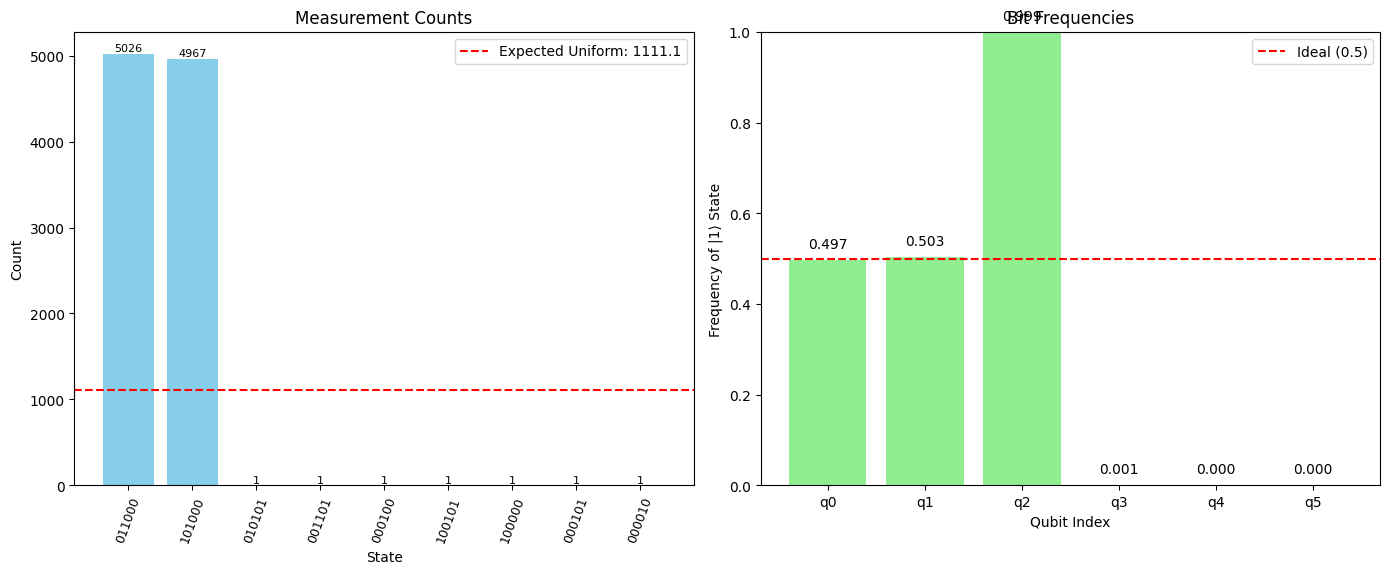

Total samples: 10000
Highest state: 011000 (5026 counts, 50.26%)
Lowest state: 000010 (1 counts, 0.01%)
✓ Strong signal detected in state 011000 (50.3%)


{'total_samples': 10000,
 'top_state': '011000',
 'top_probability': 0.5026,
 'bit_frequencies': {'q0': np.float64(0.4969),
  'q1': np.float64(0.5027),
  'q2': np.float64(0.9994),
  'q3': np.float64(0.0005),
  'q4': np.float64(0.0001),
  'q5': np.float64(0.0004)}}

In [48]:
import matplotlib.pyplot as plt
import numpy as np

def simple_visualize_results(results_dict, title="Quantum Measurement Results"):
    """
    A simple visualization for quantum measurement results.
    
    Parameters:
    -----------
    results_dict : dict
        Dictionary with quantum states as keys and counts as values
    title : str, optional
        Title for the visualization
    """
    # Basic calculations
    total_samples = sum(results_dict.values())
    n_qubits = len(list(results_dict.keys())[0])
    
    # Sort results by count (descending)
    sorted_results = dict(sorted(results_dict.items(), key=lambda x: x[1], reverse=True))
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # 1. Bar chart of states
    bars = ax1.bar(range(len(sorted_results)), sorted_results.values(), color='skyblue')
    
    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{int(height)}', ha='center', va='bottom', fontsize=8)
    
    # Set the x-tick positions and labels
    ax1.set_xticks(range(len(sorted_results)))
    ax1.set_xticklabels(list(sorted_results.keys()), rotation=70, fontsize=9)
    
    # Add uniform expectation line
    expected_uniform = total_samples / len(results_dict)
    ax1.axhline(y=expected_uniform, color='red', linestyle='--', 
                label=f'Expected Uniform: {expected_uniform:.1f}')
    
    ax1.set_title('Measurement Counts')
    ax1.set_xlabel('State')
    ax1.set_ylabel('Count')
    ax1.legend()
    
    # 2. Bit frequencies
    bit_counts = np.zeros(n_qubits)
    
    for state, count in results_dict.items():
        for i, bit in enumerate(state):
            if bit == '1':
                bit_counts[i] += count
    
    bit_frequencies = bit_counts / total_samples
    
    bars = ax2.bar(range(n_qubits), bit_frequencies, color='lightgreen')
    ax2.axhline(0.5, color='red', linestyle='dashed', label='Ideal (0.5)')
    
    # Add frequency values on top of bars
    for bar, freq in zip(bars, bit_frequencies):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{freq:.3f}', ha='center', va='bottom')
    
    ax2.set_ylim(0, 1)
    ax2.set_title('Bit Frequencies')
    ax2.set_xlabel('Qubit Index')
    ax2.set_ylabel('Frequency of |1⟩ State')
    ax2.set_xticks(range(n_qubits))
    ax2.set_xticklabels([f'q{i}' for i in range(n_qubits)])
    ax2.legend()
    
    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()
    
    # Print simple statistics
    print(f"Total samples: {total_samples}")
    print(f"Highest state: {list(sorted_results.keys())[0]} ({list(sorted_results.values())[0]} counts, {list(sorted_results.values())[0]/total_samples*100:.2f}%)")
    print(f"Lowest state: {list(sorted_results.keys())[-1]} ({list(sorted_results.values())[-1]} counts, {list(sorted_results.values())[-1]/total_samples*100:.2f}%)")
    
    # Check for clear winner (probability > 20%)
    top_prob = list(sorted_results.values())[0] / total_samples
    if top_prob > 0.2:
        print(f"✓ Strong signal detected in state {list(sorted_results.keys())[0]} ({top_prob*100:.1f}%)")
    else:
        print(f"⚠ No clear winner detected. Top state has only {top_prob*100:.1f}% probability")
    
    # Check for uniformity
    uniformity_threshold = 0.05  # 5% variation
    max_variation = max(abs(count/total_samples - 1/len(results_dict)) for count in results_dict.values())
    
    if max_variation < uniformity_threshold:
        print(f"⚠ Distribution appears close to uniform (max variation: {max_variation*100:.1f}%)")
    
    # Return a simple summary for programmatic use
    return {
        "total_samples": total_samples,
        "top_state": list(sorted_results.keys())[0],
        "top_probability": top_prob,
        "bit_frequencies": {f"q{i}": freq for i, freq in enumerate(bit_frequencies)}
    }

simple_visualize_results(counts, "")

In [ ]:
import qiskit
from qiskit.quantum_info import Statevector
import numpy as np
import math

# --- Configuration ---
n_search_qubits = 4
try:
    # *** USE THE QISKIT PHASE ORACLE GENERATED BY phaseflip_circuit ***
    phase_oracle_qiskit = oracle
    total_qubits = phase_oracle_qiskit.num_qubits
    print(f"Verifying PHASE oracle with N={n_search_qubits} search qubits.")
    print(f"Oracle has {total_qubits} total qubits.")
    # Phase oracle might use fewer qubits if output isn't explicit
    if total_qubits < n_search_qubits:
         raise ValueError("Phase oracle has fewer qubits than search qubits.")
except NameError:
    print("Error: 'phase_oracle_qiskit' variable not defined.")
    exit()
except Exception as e:
    print(f"Error accessing oracle: {e}")
    exit()

search_qubit_indices = list(range(n_search_qubits))
# Ancillae are any qubits beyond the search space
ancilla_indices = list(range(n_search_qubits, total_qubits))

# Expected solution state (Qiskit order q3..q0)
expected_solution_str_qiskit_order = '0111'
# A non-solution state
non_solution_str_qiskit_order = '0000'

# --- Test Function ---
def verify_phase_oracle_state(oracle, input_label_qiskit_order):
    n_in = len(input_label_qiskit_order)
    total_q = oracle.num_qubits
    n_anc = total_q - n_in

    print(f"\n--- Verifying input: '{input_label_qiskit_order}' ---")

    # Initial state: |input> |0...0>_anc
    full_initial_label = ('0' * n_anc) + input_label_qiskit_order
    print(f"Initial state label (q_{total_q-1}...q_0): {full_initial_label}")

    try:
        initial_sv = Statevector.from_label(full_initial_label)
    except Exception as e:
        print(f"Error creating initial Statevector: {e}")
        return False, False # Indicate failure

    print("Applying phase oracle...")
    try:
        final_sv = initial_sv.evolve(oracle)
    except Exception as e:
        print(f"Error evolving statevector with phase oracle: {e}")
        return False, False # Indicate failure

    # Analyze final state
    print("Analyzing final state...")
    amps_initial = initial_sv.to_dict(decimals=9)
    amps_final = final_sv.to_dict(decimals=9)

    initial_amp = amps_initial.get(full_initial_label, 0)
    final_amp = amps_final.get(full_initial_label, 0)

    print(f"Amplitude for state {full_initial_label}: Initial={initial_amp:.4f} --> Final={final_amp:.4f}")

    # Check phase change (expect -1 for solution, +1 for non-solution)
    phase_correct = False
    if abs(initial_amp) > 1e-9 and abs(final_amp) > 1e-9:
        relative_phase = final_amp / initial_amp
        if input_label_qiskit_order == expected_solution_str_qiskit_order:
            # Expect phase ~ -1
            if np.isclose(relative_phase, -1.0):
                phase_correct = True
                print("Phase check: Correct (-1) phase found for solution ✅")
            else:
                print(f"Phase check: Incorrect phase {relative_phase:.4f} found for solution (expected -1) ❌")
        else:
            # Expect phase ~ +1
            if np.isclose(relative_phase, 1.0):
                phase_correct = True
                print("Phase check: Correct (+1) phase found for non-solution ✅")
            else:
                print(f"Phase check: Incorrect phase {relative_phase:.4f} found for non-solution (expected +1) ❌")
    else:
        print("Phase check: Cannot determine phase due to zero amplitude.")

    # Check ancillae cleanliness
    ancilla_clean = True
    for state_label, amp in amps_final.items():
        if abs(amp) > 1e-9:
            # Check if it's the expected main state
            if state_label == full_initial_label:
                continue
            # If it's another state, check if ancillae were disturbed
            is_main_input = state_label.endswith(input_label_qiskit_order)
            ancilla_part_dirty = False
            for idx in ancilla_indices:
                string_index = (total_q - 1) - idx
                if state_label[string_index] == '1':
                     ancilla_part_dirty = True
                     break
            # Allow non-zero amplitude only if it's the original input state with clean ancillae
            if not (state_label == full_initial_label and not ancilla_part_dirty) :
                 # Check if maybe only the input part changed (shouldn't happen)
                 input_part_final = state_label[len(ancilla_indices):]
                 if input_part_final != input_label_qiskit_order:
                      print(f"Ancilla/Input state incorrect! State: {state_label}, Amp: {amp:.4f}. Input changed! ❌")
                 elif ancilla_part_dirty:
                      print(f"Ancilla/Input state incorrect! State: {state_label}, Amp: {amp:.4f}. Ancilla dirty! ❌")
                 # If input is same and ancilla clean, it must be the main state already handled.
                 # This logic might need refinement if complex states appear.

                 # Simplified check: only the original state should have non-zero amplitude
                 if state_label != full_initial_label:
                     print(f"State other than initial found! State: {state_label}, Amp: {amp:.4f}. Possible ancilla/logic error. ❌")
                     ancilla_clean = False


    if ancilla_clean:
         # Double check based on state labels found
         ancilla_truly_clean = True
         for state_label, amp in amps_final.items():
              if abs(amp) > 1e-9:
                   for idx in ancilla_indices:
                       string_index = (total_q - 1) - idx
                       if state_label[string_index] == '1':
                            ancilla_truly_clean = False
                            break
                   if not ancilla_truly_clean: break
         if ancilla_truly_clean:
             print("Ancilla Cleanliness: All ancillae remained |0> ✅")
         else:
              print("Ancilla Cleanliness: Ancillae became non-zero ❌")
              ancilla_clean = False # Ensure it's marked false

    return phase_correct, ancilla_clean

# --- Run Verification ---
sol_phase_ok, sol_anc_ok = verify_phase_oracle_state(phase_oracle_qiskit, expected_solution_str_qiskit_order)
nonsol_phase_ok, nonsol_anc_ok = verify_phase_oracle_state(phase_oracle_qiskit, non_solution_str_qiskit_order)

print("\n--- Phase Oracle Verification Summary ---")
if sol_phase_ok and sol_anc_ok and nonsol_phase_ok and nonsol_anc_ok:
    print("✅ Phase oracle appears correct and keeps ancillae clean.")
else:
    print("❌ Phase oracle verification FAILED.")
    if not sol_phase_ok: print("  - Incorrect phase for solution state.")
    if not nonsol_phase_ok: print("  - Incorrect phase for non-solution state.")
    if not sol_anc_ok or not nonsol_anc_ok: print("  - Ancilla qubits did not remain |0>.")

In [ ]:
import qiskit
from qiskit.quantum_info import Statevector
import numpy as np
import math

# --- Configuration ---
# Assume opt_oracle is your Qiskit circuit for the N=4 case
# You confirmed the N=4 oracle works correctly via Statevector.evolve previously.
n_search_qubits = N # N=4 problem
try:
    opt_oracle = opt_oracle # Make sure this variable holds the N=4 Qiskit oracle circuit
    total_qubits = opt_oracle.num_qubits
    print(f"Using N={n_search_qubits} search qubits.")
    print(f"Oracle has {total_qubits} total qubits.")
    if total_qubits < n_search_qubits + 1:
        raise ValueError("Oracle has fewer qubits than needed for inputs + output.")
except NameError:
    print("Error: 'opt_oracle' variable not defined. Please ensure it holds the Qiskit circuit.")
    exit()
except Exception as e:
    print(f"Error accessing oracle: {e}")
    exit()

output_qubit_index = n_search_qubits
search_qubit_indices = list(range(n_search_qubits))
ancilla_indices = list(range(output_qubit_index + 1, total_qubits))

# Define the expected solution state string (Qiskit order: q_{n-1}...q_0)
# For N=4, solution is vertices 0 and 2 -> |0101>
expected_solution_str_qiskit_order = '0101'

# --- 1. Prepare Initial State ---
print("\n--- Step 1: Preparing Initial State ---")
init_circuit = qiskit.QuantumCircuit(total_qubits, name="Init")
# Superposition on search qubits
init_circuit.h(search_qubit_indices)
# Prepare output qubit in |-⟩ state for phase kickback
init_circuit.x(output_qubit_index)
init_circuit.h(output_qubit_index)
# Ancillae remain |0⟩ (default)

# Create statevector
sv_initial = Statevector(init_circuit)
print("Initial state prepared.")
# Optional: Print state for very small N
# if total_qubits <= 6: print(sv_initial)

# --- 2. Apply Oracle ---
print("\n--- Step 2: Applying Oracle ---")
try:
    sv_after_oracle = sv_initial.evolve(opt_oracle)
    print("Oracle applied to statevector.")
except Exception as e:
    print(f"Error evolving statevector with oracle: {e}")
    exit()

# --- 3. Analyze Oracle Effect ---
print("\n--- Step 3: Analyzing Oracle Effect ---")
probs_after_oracle = sv_after_oracle.probabilities_dict(decimals=9)
non_zero_states_oracle = {k: v for k, v in probs_after_oracle.items() if v > 1e-12}

phase_flipped = False
ancilla_clean_oracle = True
print(f"States with non-zero probability ({len(non_zero_states_oracle)} states):")

# We need amplitudes to check phase
amps_initial = sv_initial.to_dict(decimals=9)
amps_after_oracle = sv_after_oracle.to_dict(decimals=9)

# Find amplitude of solution and a non-solution BEFORE oracle
sol_label_full = ('0' * len(ancilla_indices)) + '1' + expected_solution_str_qiskit_order # |-⟩ on output
nonsol_label_full = ('0' * len(ancilla_indices)) + '1' + ('0' * n_search_qubits)       # |-⟩ on output

amp_sol_initial = amps_initial.get(sol_label_full, 0)
amp_nonsol_initial = amps_initial.get(nonsol_label_full, 0)

print(f"Initial Amp Solution   ({sol_label_full}): {amp_sol_initial}")
print(f"Initial Amp Non-Sol 0 ({nonsol_label_full}): {amp_nonsol_initial}")

# Check solution state phase AFTER oracle
amp_sol_after = amps_after_oracle.get(sol_label_full, 0)
amp_nonsol_after = amps_after_oracle.get(nonsol_label_full, 0)

print(f"After Oracle Amp Solution   ({sol_label_full}): {amp_sol_after}")
print(f"After Oracle Amp Non-Sol 0 ({nonsol_label_full}): {amp_nonsol_after}")

# Check relative phase flip (handle potential zero amplitudes)
if abs(amp_sol_initial) > 1e-9 and abs(amp_nonsol_initial) > 1e-9 and \
   abs(amp_sol_after) > 1e-9 and abs(amp_nonsol_after) > 1e-9:
    relative_phase_initial = amp_sol_initial / amp_nonsol_initial
    relative_phase_after = amp_sol_after / amp_nonsol_after
    if np.isclose(relative_phase_after, -relative_phase_initial):
        phase_flipped = True
        print("Phase flip detected for solution state: ✅")
    else:
        print(f"Phase flip NOT detected for solution state: ❌ (Initial Rel Phase: {relative_phase_initial:.3f}, After Oracle Rel Phase: {relative_phase_after:.3f})")
else:    # *** REMOVED: Phase kickback preparation ***

    print("Could not reliably check phase flip due to near-zero amplitudes.")
    # Check if solution amplitude itself flipped sign relative to non-solution
    if amp_nonsol_initial != 0 and amp_nonsol_after != 0 and np.sign(amp_sol_initial.real) != np.sign(amp_sol_after.real) and np.sign(amp_nonsol_initial.real) == np.sign(amp_nonsol_after.real):
         phase_flipped = True
         print("(Sign flip of solution amplitude detected)")


# Check ancillae cleanliness after oracle
for state_label, amp in amps_after_oracle.items():
     if abs(amp) > 1e-9:
         for idx in ancilla_indices:
             string_index = (total_qubits - 1) - idx
             if state_label[string_index] == '1':
                 print(f"Ancilla dirty after oracle! State: {state_label}, Amp: {amp}: ❌")
                 ancilla_clean_oracle = False
                 # break # Uncomment to stop after first dirty ancilla

if ancilla_clean_oracle:
    print("Ancillae clean after oracle: ✅")

# --- 4. Prepare Diffusion Operator ---
print("\n--- Step 4: Preparing Diffusion Operator Circuit ---")
# Diffusion operator acts ONLY on the n search qubits
diffuser_circuit = qiskit.QuantumCircuit(n_search_qubits, name="Diffuser")
diffuser_circuit.h(search_qubit_indices)
diffuser_circuit.x(search_qubit_indices)

# MCZ part
controls = list(range(n_search_qubits - 1)) # 0..n-2
target = n_search_qubits - 1              # n-1

if n_search_qubits == 1:
    diffuser_circuit.z(0)
elif n_search_qubits > 1:
    diffuser_circuit.h(target)
    if controls: # Check if controls list is not empty (n > 1)
        diffuser_circuit.mcp(np.pi, controls, target)
    # Note: Qiskit's mcp might handle n=2 case automatically where controls is empty
    # If n=2, mcp(pi, [0], 1) is just CZ or CP(pi, 0, 1)
    # Let's assume mcp handles it or add specific check if needed
    diffuser_circuit.h(target)

diffuser_circuit.x(search_qubit_indices)
diffuser_circuit.h(search_qubit_indices)
print("Diffusion circuit created:")
# print(diffuser_circuit.draw(output='text')) # Optional: Draw for small N


# --- 5. Apply Diffusion ---
print("\n--- Step 5: Applying Diffusion Operator ---")
# IMPORTANT: Evolve using the state AFTER the oracle, and specify qargs
try:
    # Apply diffuser only to the search qubits
    sv_after_diffusion = sv_after_oracle.evolve(diffuser_circuit, qargs=search_qubit_indices)
    print("Diffusion operator applied to statevector.")
except Exception as e:
    print(f"Error evolving statevector with diffusion operator: {e}")
    exit()

# --- 6. Analyze Diffusion Effect ---
print("\n--- Step 6: Analyzing Diffusion Effect ---")
probs_after_diffusion = sv_after_diffusion.probabilities_dict(decimals=9)
non_zero_states_diffusion = {k: v for k, v in probs_after_diffusion.items() if v > 1e-12}

print(f"States with non-zero probability ({len(non_zero_states_diffusion)} states):")

# Get probabilities of the specific states
prob_sol_initial = abs(amp_sol_initial)**2
prob_nonsol_initial = abs(amp_nonsol_initial)**2

prob_sol_after_diffusion = probs_after_diffusion.get(sol_label_full, 0)
prob_nonsol_after_diffusion = probs_after_diffusion.get(nonsol_label_full, 0)

print(f"\nProb Solution   ({sol_label_full}): Initial={prob_sol_initial:.4f} --> After Diffusion={prob_sol_after_diffusion:.4f}")
print(f"Prob Non-Sol 0 ({nonsol_label_full}): Initial={prob_nonsol_initial:.4f} --> After Diffusion={prob_nonsol_after_diffusion:.4f}")

amplification_occurred = False
if prob_sol_after_diffusion > prob_sol_initial * 1.1: # Check for >10% increase
     amplification_occurred = True
     print("Amplitude amplification detected: ✅")
else:
     print("Amplitude amplification NOT detected: ❌")

# Final check on ancillae after diffusion (should ideally remain clean)
ancilla_clean_diffusion = True
for state_label, prob in probs_after_diffusion.items():
     if prob > 1e-9:
         for idx in ancilla_indices:
             string_index = (total_qubits - 1) - idx
             if state_label[string_index] == '1':
                 print(f"Ancilla dirty after diffusion! State: {state_label}, Prob: {prob}: ❌")
                 ancilla_clean_diffusion = False
                 # break

if ancilla_clean_diffusion:
    print("Ancillae clean after diffusion: ✅")

print("\n--- Overall Analysis ---")
if phase_flipped and ancilla_clean_oracle and amplification_occurred and ancilla_clean_diffusion:
     print("✅ Step-by-step simulation successful for one iteration.")
else:
     print("❌ Step-by-step simulation failed. Issues detected:")
     if not phase_flipped: print("  - Oracle did not apply expected phase flip.")
     if not ancilla_clean_oracle: print("  - Oracle left ancillae dirty.")
     if not amplification_occurred: print("  - Diffusion operator did not amplify solution probability.")
     if not ancilla_clean_diffusion: print("  - Diffusion operator left ancillae dirty (unexpected).")

In [ ]:
import qiskit
from qiskit.quantum_info import Statevector
import numpy as np
import math

# --- Configuration ---
n_search_qubits = 4 # N=4 problem
try:
    opt_oracle = opt_oracle # Make sure this variable holds the N=4 Qiskit oracle circuit
    total_qubits = opt_oracle.num_qubits
    print(f"Using N={n_search_qubits} search qubits.")
    print(f"Oracle has {total_qubits} total qubits.")
    if total_qubits < n_search_qubits + 1:
        raise ValueError("Oracle has fewer qubits than needed for inputs + output.")
except NameError:
    print("Error: 'opt_oracle' variable not defined. Please ensure it holds the Qiskit circuit.")
    exit()
except Exception as e:
    print(f"Error accessing oracle: {e}")
    exit()

output_qubit_index = n_search_qubits
search_qubit_indices = list(range(n_search_qubits))
ancilla_indices = list(range(output_qubit_index + 1, total_qubits))
expected_solution_str_qiskit_order = '0101' # Qiskit order q3..q0

# --- Build Circuit for ONE Iteration ---
print("\n--- Building Circuit for One Iteration ---")
one_iter_circuit = qiskit.QuantumCircuit(total_qubits, n_search_qubits) # Classical bits only for final measure

# 1. Initialization
one_iter_circuit.h(search_qubit_indices)
one_iter_circuit.x(output_qubit_index)
one_iter_circuit.h(output_qubit_index)
one_iter_circuit.barrier(label="Init") # Add barrier for clarity

# 2. Oracle
one_iter_circuit.compose(opt_oracle, inplace=True)
one_iter_circuit.barrier(label="Oracle")

# 3. Diffusion Operator
one_iter_circuit.h(search_qubit_indices)
one_iter_circuit.x(search_qubit_indices)
# MCZ part
controls = list(range(n_search_qubits - 1))
target = n_search_qubits - 1
if n_search_qubits == 1:
    one_iter_circuit.z(0)
elif n_search_qubits > 1:
    one_iter_circuit.h(target)
    if controls:
        one_iter_circuit.mcp(np.pi, controls, target)
    one_iter_circuit.h(target)
one_iter_circuit.x(search_qubit_indices)
one_iter_circuit.h(search_qubit_indices)
one_iter_circuit.barrier(label="Diffusion")

print("Circuit for one iteration built.")
# print(one_iter_circuit.draw(output='text')) # Optional: Draw it

# --- Simulate the Statevector AFTER One Iteration ---
print("\n--- Simulating Statevector After One Iteration ---")
try:
    sv_after_one_iteration = Statevector(one_iter_circuit)
    print("Statevector calculated.")
except Exception as e:
    print(f"Error creating statevector from one_iter_circuit: {e}")
    exit()

# --- Analyze the Final State ---
print("\n--- Analyzing State After One Iteration ---")
probs_final = sv_after_one_iteration.probabilities_dict(decimals=9)
amps_final = sv_after_one_iteration.to_dict(decimals=9)

# Construct the expected final label for the solution state
# After oracle, output is |1>, after diffusion it remains unchanged ideally
# So, label is |0...0>_anc |1>_out |solution>_in
sol_label_full_expected = ('0' * len(ancilla_indices)) + '1' + expected_solution_str_qiskit_order
nonsol_label_full_expected = ('0' * len(ancilla_indices)) + '1' + ('0' * n_search_qubits) # Check |0000> state

prob_sol_final = probs_final.get(sol_label_full_expected, 0)
prob_nonsol_final = probs_final.get(nonsol_label_full_expected, 0)

# Calculate initial probabilities (uniform superposition)
initial_prob_per_state = 1 / (2**n_search_qubits)

print(f"Prob Solution   ({sol_label_full_expected}): Initial={initial_prob_per_state:.4f} --> After 1 Iteration={prob_sol_final:.4f}")
print(f"Prob Non-Sol 0 ({nonsol_label_full_expected}): Initial={initial_prob_per_state:.4f} --> After 1 Iteration={prob_nonsol_final:.4f}")

amplification_occurred = False
# Check if solution probability significantly increased AND non-solution decreased
if prob_sol_final > initial_prob_per_state * 1.5 and prob_nonsol_final < initial_prob_per_state * 0.9:
     amplification_occurred = True
     print("Amplitude amplification detected: ✅")
else:
     print("Amplitude amplification NOT detected: ❌")

# Check ancillae cleanliness after full iteration
ancilla_clean_final = True
for state_label, prob in probs_final.items():
     if prob > 1e-9:
         # Check output qubit state - should ideally be |1> for these states
         output_string_index = (total_qubits - 1) - output_qubit_index
         if state_label[output_string_index] != '1':
              print(f"Warning: Output qubit q{output_qubit_index} not |1> in state {state_label} (Prob: {prob:.4f})")

         # Check ancilla qubits
         for idx in ancilla_indices:
             string_index = (total_qubits - 1) - idx
             if state_label[string_index] == '1':
                 print(f"Ancilla dirty after full iteration! State: {state_label}, Prob: {prob}: ❌")
                 ancilla_clean_final = False
                 # break

if ancilla_clean_final:
    print("Ancillae clean after full iteration: ✅")
else:
     print("Ancillae dirty after full iteration: ❌")

In [ ]:
import qiskit
from qiskit.quantum_info import Statevector
import numpy as np
import math
from qiskit import transpile
from qiskit_aer import AerSimulator # Needed for backend info

# --- Configuration ---
n_search_qubits = 4
try:
    opt_oracle = opt_oracle # N=4 oracle
    total_qubits = opt_oracle.num_qubits
    print(f"Using N={n_search_qubits} search qubits.")
    print(f"Oracle has {total_qubits} total qubits.")
except NameError: # ... (error handling)
    print("Error: 'opt_oracle' variable not defined.")
    exit()
except Exception as e: # ... (error handling)
    print(f"Error accessing oracle: {e}")
    exit()

output_qubit_index = n_search_qubits
search_qubit_indices = list(range(n_search_qubits))
ancilla_indices = list(range(output_qubit_index + 1, total_qubits))
expected_solution_str_qiskit_order = '0101'

# --- Build Circuit for ONE Iteration ---
print("\n--- Building Circuit for One Iteration ---")
one_iter_circuit = qiskit.QuantumCircuit(total_qubits, n_search_qubits)
one_iter_circuit.h(search_qubit_indices)
one_iter_circuit.x(output_qubit_index)
one_iter_circuit.h(output_qubit_index)
one_iter_circuit.barrier(label="Init")
one_iter_circuit.compose(opt_oracle, inplace=True)
one_iter_circuit.barrier(label="Oracle")
# Diffusion Operator
one_iter_circuit.h(search_qubit_indices)
one_iter_circuit.x(search_qubit_indices)
controls = list(range(n_search_qubits - 1))
target = n_search_qubits - 1
if n_search_qubits > 1:
    one_iter_circuit.h(target)
    if controls: one_iter_circuit.mcp(np.pi, controls, target)
    one_iter_circuit.h(target)
elif n_search_qubits == 1: one_iter_circuit.z(0)
one_iter_circuit.x(search_qubit_indices)
one_iter_circuit.h(search_qubit_indices)
one_iter_circuit.barrier(label="Diffusion")
print("Circuit built.")

# --- Explicit Transpilation ---
print("\n--- Transpiling the One-Iteration Circuit ---")
simulator = AerSimulator() # Need backend info for basis gates
basis_gates = simulator.configuration().basis_gates
# Try minimal optimization first
transpiled_one_iter = transpile(one_iter_circuit, backend=simulator, basis_gates=basis_gates, optimization_level=0)
print("Circuit transpiled (level 0).")
print(transpiled_one_iter.draw(output='text')) # Optional

# --- Simulate the Statevector from TRANSPILATION ---
print("\n--- Simulating Statevector from Transpiled Circuit ---")
try:
    # IMPORTANT: Use the transpiled circuit here
    sv_after_one_iteration = Statevector(transpiled_one_iter)
    print("Statevector calculated from transpiled circuit.")
except Exception as e:
    print(f"Error creating statevector from transpiled circuit: {e}")
    exit()

# --- Analyze the Final State (same analysis code as before) ---
print("\n--- Analyzing State After One Iteration (from Transpiled) ---")
probs_final = sv_after_one_iteration.probabilities_dict(decimals=9)
amps_final = sv_after_one_iteration.to_dict(decimals=9)
sol_label_full_expected = ('0' * len(ancilla_indices)) + '1' + expected_solution_str_qiskit_order
nonsol_label_full_expected = ('0' * len(ancilla_indices)) + '1' + ('0' * n_search_qubits)
prob_sol_final = probs_final.get(sol_label_full_expected, 0)
prob_nonsol_final = probs_final.get(nonsol_label_full_expected, 0)
initial_prob_per_state = 1 / (2**n_search_qubits)
print(f"Prob Solution   ({sol_label_full_expected}): Initial={initial_prob_per_state:.4f} --> After 1 Iteration={prob_sol_final:.4f}")
print(f"Prob Non-Sol 0 ({nonsol_label_full_expected}): Initial={initial_prob_per_state:.4f} --> After 1 Iteration={prob_nonsol_final:.4f}")
amplification_occurred = False
if prob_sol_final > initial_prob_per_state * 1.5 and prob_nonsol_final < initial_prob_per_state * 0.9:
     amplification_occurred = True
     print("Amplitude amplification detected: ✅")
else:
     print("Amplitude amplification NOT detected: ❌")
ancilla_clean_final = True
for state_label, prob in probs_final.items():
     if prob > 1e-9:
         output_string_index = (total_qubits - 1) - output_qubit_index
         if state_label[output_string_index] != '1':
              print(f"Warning: Output qubit q{output_qubit_index} not |1> in state {state_label} (Prob: {prob:.4f})")
         for idx in ancilla_indices:
             string_index = (total_qubits - 1) - idx
             if state_label[string_index] == '1':
                 print(f"Ancilla dirty after full iteration! State: {state_label}, Prob: {prob}: ❌")
                 ancilla_clean_final = False
if ancilla_clean_final: print("Ancillae clean after full iteration: ✅")
else: print("Ancillae dirty after full iteration: ❌")